This notebook shows how we transform ANN 6 from keras to pytorch 

In [3]:
import tensorflow as tf
from cbrain import *
import torch as to
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda,Dropout
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

define some hyperparameters 

In [4]:
original_dim_input=109  # CBRAIN input node size

original_dim_output=int(112) # CBRAIN output node size 


input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 433

batch_size= 11162





In [5]:
#load keras ANN 6
ANN_6=ke.models.load_model('real_geography/ANNs/ANNs_lin/ANN_6/ANN_6_CRM_lin_model.h5')
ANN_6.summary()
ANN_6_weights=ANN_6.get_weights()

batch_size= 11162


Model: "ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 109)]             0         
                                                                 
 dense (Dense)               (None, 433)               47630     
                                                                 
 dense_1 (Dense)             (None, 433)               187922    
                                                                 
 dense_2 (Dense)             (None, 433)               187922    
                                                                 
 dense_3 (Dense)             (None, 433)               187922    
                                                                 
 dense_4 (Dense)             (None, 433)               187922    
                                                                 
 dense_5 (Dense)             (None, 112)               48608   

import pytorch 

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
# construct ANN 6 in pytorch 
class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()
        self.X_1=nn.Linear(109,323)
        self.X_2=nn.Linear(323,323)
        self.X_3=nn.Linear(323,323)
        self.X_4=nn.Linear(323,323)
        self.X_5=nn.Linear(323,323)
        self.X_6=nn.Linear(323,112)
        self.X_7=nn.Linear(112,112)

    def forward(self,x):
        x=F.elu_(self.X_1(x))
        x=F.elu_(self.X_2(x))
        x=F.elu_(self.X_3(x))
        x=F.elu_(self.X_4(x))
        x=F.elu_(self.X_5(x))
        x=F.elu_(self.X_6(x))
        x=self.X_7(x)

        
        return x
    
    
        



        


In [8]:
# initialize ANN 6 
ANN_6_torch=ANN()
print(ANN_6_torch)

ANN(
  (X_1): Linear(in_features=109, out_features=323, bias=True)
  (X_2): Linear(in_features=323, out_features=323, bias=True)
  (X_3): Linear(in_features=323, out_features=323, bias=True)
  (X_4): Linear(in_features=323, out_features=323, bias=True)
  (X_5): Linear(in_features=323, out_features=323, bias=True)
  (X_6): Linear(in_features=323, out_features=112, bias=True)
  (X_7): Linear(in_features=112, out_features=112, bias=True)
)


In [19]:
# load keras weights and bias into pytorch model 
ANN_6_torch.X_1.weight.data=to.from_numpy(np.transpose(ANN_6_weights[0]))
ANN_6_torch.X_1.bias.data=to.from_numpy(np.transpose(ANN_6_weights[1]))
ANN_6_torch.X_2.weight.data=to.from_numpy(np.transpose(ANN_6_weights[2]))
ANN_6_torch.X_2.bias.data=to.from_numpy(np.transpose(ANN_6_weights[3]))
ANN_6_torch.X_3.weight.data=to.from_numpy(np.transpose(ANN_6_weights[4]))
ANN_6_torch.X_3.bias.data=to.from_numpy(np.transpose(ANN_6_weights[5]))
ANN_6_torch.X_4.weight.data=to.from_numpy(np.transpose(ANN_6_weights[6]))
ANN_6_torch.X_4.bias.data=to.from_numpy(np.transpose(ANN_6_weights[7]))
ANN_6_torch.X_5.weight.data=to.from_numpy(np.transpose(ANN_6_weights[8]))
ANN_6_torch.X_5.bias.data=to.from_numpy(np.transpose(ANN_6_weights[9]))
ANN_6_torch.X_6.weight.data=to.from_numpy(np.transpose(ANN_6_weights[10]))
ANN_6_torch.X_6.bias.data=to.from_numpy(np.transpose(ANN_6_weights[11]))
ANN_6_torch.X_7.weight.data=to.from_numpy(np.transpose(ANN_6_weights[12]))
ANN_6_torch.X_7.bias.data=to.from_numpy(np.transpose(ANN_6_weights[13]))


In [20]:
#define input vars and output vars 
in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values




# defining the scaling dict for the ANN training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}





# load vertical axis in pressure coords 

from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


# load test data set 

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [21]:
from cbrain.save_weights import save_norm

predict with keras and pytorch 

In [23]:
pred_keras= ANN_6.predict(val_gen_II[300][0])

432/432 [==============================] - 1s 1ms/step


In [24]:
print(pred_keras.shape)
pred_keras

(13824, 112)


array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.9998840e-01,  5.8136082e-01,  6.6066021e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.9998840e-01,  5.8136082e-01,  6.6066021e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.9998840e-01,  5.8136082e-01,  6.6066021e-01],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         5.9998840e-01,  5.8136082e-01,  6.6066021e-01],
       [ 1.1175871e-08,  3.7252903e-09, -1.3969839e-09, ...,
         5.9998852e-01,  5.8136076e-01,  6.6066021e-01],
       [ 1.1175871e-08,  3.7252903e-09, -1.3969839e-09, ...,
         5.9998852e-01,  5.8136076e-01,  6.6066021e-01]], dtype=float32)

In [25]:
pred_pytorch=ANN_6_torch(to.from_numpy(val_gen_II[300][0]))

In [26]:
pred_pytorch

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5814, 0.6607],
        [0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5814, 0.6607],
        [0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5814, 0.6607],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5814, 0.6607],
        [0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5814, 0.6607],
        [0.0000, 0.0000, 0.0000,  ..., 0.6000, 0.5814, 0.6607]],
       grad_fn=<AddmmBackward0>)

In [27]:
# get weights and biases 
module = to.jit.trace(ANN_6_torch.forward, to.from_numpy(val_gen_II[300][0]))

In [28]:
# get entire model  
mod = to.jit.trace(ANN_6_torch, to.from_numpy(val_gen_II[300][0]))

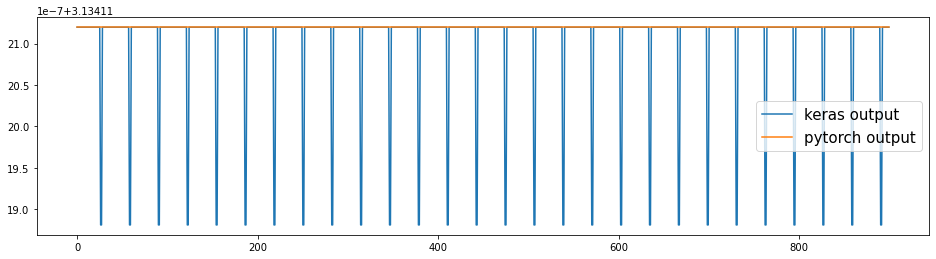

In [29]:
plt.figure(1,(16,4))
plt.plot(pred_keras[100:1000,106],label='keras output')
plt.plot(pred_pytorch.detach().numpy()[100:1000,106],label='pytorch output')
plt.legend(fontsize=15)

In [30]:
a=np.isclose(pred_keras,pred_pytorch.detach().numpy(),atol=2E-6)

In [31]:
a.shape

(13824, 112)

In [32]:
np.where(a==False)[0].size

0

In [33]:
np.where(a==True)[0].size

1548288

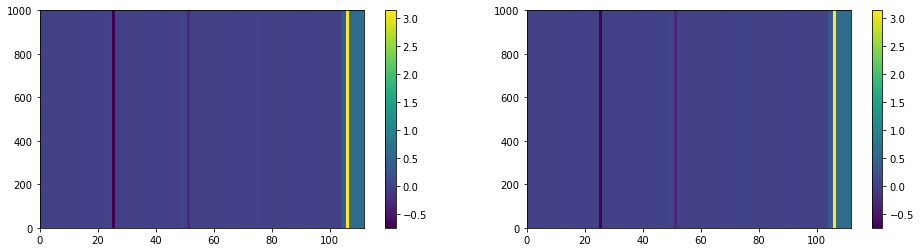

In [34]:
plt.figure(1,(16,4))
plt.subplot(1,2,1)
plt.pcolor(pred_keras[0:1000])
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolor(pred_pytorch.detach().numpy()[0:1000])
plt.colorbar()

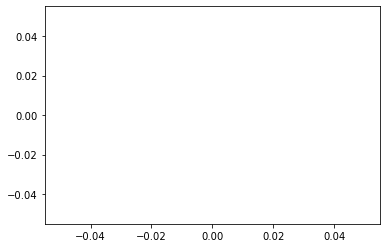

In [35]:
plt.plot(np.where(pred_keras-pred_pytorch.detach().numpy()>=1E-6)[1],'x')#np.max(pred_keras-pred_pytorch.detach().numpy()))

In [36]:
# save weights and biases 
to.save(ANN_6_torch,'real_geography/ANNs/ANN_6/ANN_6_CRM_lin.pt')

In [37]:
# save entire model 
to.jit.save(mod,'real_geography/ANNs/ANN_6/ANN_6_CRM_lin_jit.pt')